In [21]:
import os
import pandas as pd
import csv
import datetime

In [22]:
window = 2
number_of_documents = 1

In [23]:
import urllib
from bs4 import BeautifulSoup

In [24]:
web_page = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

In [25]:
import requests 
import re

In [26]:
response = requests.get(web_page)

In [27]:
soup_obj = BeautifulSoup(response.text,'lxml')

In [28]:
links_nonprepared = soup_obj.find_all('a', href=re.compile('yellow_tripdata'))

In [29]:
links = []
for link in links_nonprepared:
    links.append(link.attrs['href'])

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

In [33]:
class RollingMean():
    def __init__(self, window):
        self.window = window
        self.dataframe = pd.DataFrame()
                
    def data_preparation(self, data, input_date):
        data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
        data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')
        data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.date
        data['tpep_dropoff_datetime'] = data['tpep_dropoff_datetime'].dt.date
        data['TEMP_pickup_datetime'] = data['tpep_pickup_datetime'].map(lambda x: x.strftime('%Y-%m'))
        data['input_date'] = input_date
        data['input_date'] = data['input_date'].map(lambda x: x.strftime('%Y-%m'))
        data = data[data['TEMP_pickup_datetime'] == data['input_date']][['tpep_pickup_datetime','trip_distance']]
        return data
            
    def append(self, data):
        self.dataframe = self.dataframe.append(data)
        print(self.dataframe.head())
        print("***************************")
    
    def calculate(self,data):
        data = data.groupby(['tpep_pickup_datetime']).mean() 
        data['RM'] = data['trip_distance'].rolling(self.window).mean()
        return data
        
    def plot(self,x,y,i):
        ax.plot(x, y, color='b')
        ax.set_title("Rolling mean")
        ax.set_xlabel("Window index")
        ax.set_ylabel("Mean by the window")
        fig.canvas.draw()
        ax.set_xlim(left=max(0, i-50), right=i+50)

In [34]:
obj = RollingMean(window)

In [35]:
for ix,link in enumerate(links):
    match = re.search('\d{4}-\d{2}', link)
    input_date = datetime.datetime.strptime(match.group(), '%Y-%m').date()
    response = requests.get(link)
    with open(os.path.split(link)[1], 'wb') as f:
        f.write(response.content)
    data = pd.read_csv(link) 
    data = pd.read_csv(link,delimiter =",",quoting=csv.QUOTE_NONE, quotechar="")
    data = obj.data_preparation(data, input_date)
    obj.append(data)
    if ix == number_of_documents-1:
        break

  tpep_pickup_datetime  trip_distance
0           2018-01-01            0.5
1           2018-01-01            2.7
2           2018-01-01            0.8
3           2018-01-01           10.2
4           2018-01-01            2.5
***************************


In [36]:
data = obj.calculate(obj.dataframe)

<IPython.core.display.Javascript object>


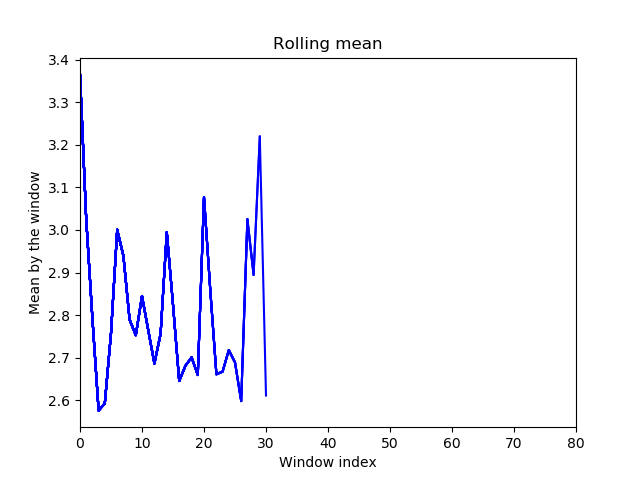

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

In [39]:
x = []
y = []
for i,j in enumerate(data['trip_distance']):
    x.append(i)
    y.append(j)
    obj.plot(x,y,i)